# Amazon Fine-Food Reviews Dataset

## Summary of the dataset:

* The data consist of 568454 rows and 10 columns.

* The data consist of following information.
    * The unique id of each product(ProductId)
    * Unique Id of each user(UserId)
    * a rating from 1 to 5(Score)
    * time at which review was posted(Time)
    * summary of the review given(Summary)
    * review given by the customer(Text)
* Columns that were removed.
    * profile name - (the nick name of the user)
    * Helpfulness numerator - (was the review helpful to others)
    * Helpfulness denominator - (helpfull+ not helpful)
    
* Column Data-types:
    * ProductId - object type
    * UserId - object type
    * Score - int(1-5)
    * Time - time stamp
    * summary - text data
    * text - text data
* There are 27 null values in summary column and else everything is non-null.

In [1]:
#importing necessary libraries
import re
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#reading data
df=pd.read_csv(r'D:\study material\ML\Datasets\amazon-fine-food-reviews\Reviews.csv',nrows=50000)

In [3]:
df=df[df['Score']!=3]

In [4]:
df.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
49995,49996,B00430B73W,AKW867T7C6HF8,HWJ3,0,0,5,1261180800,Grown to really like them,My sister introduced me to these. They have be...
49996,49997,B00430B73W,A2PEHNEDMHOYTW,L. Allen,0,0,5,1258934400,Healthy Snack at a great price!,A friend recommended these bars and I fell in ...
49997,49998,B00430B73W,A2QH2KF2IAB143,"J. A. Meyers ""Jan""",0,0,5,1257379200,Raw Revolution Hazelnut Cashew,Fabulous! I take one to work with me every da...
49998,49999,B00430B73W,AMX286UGXISMA,Aaron Dragushan,0,0,4,1247702400,"fantastic, but chew carefully",I love these bars and will continue to buy the...
49999,50000,B00430B73W,A3042WJDYJ22S8,"Sunny Side Up ""CoffeeBuzz""",0,0,5,1178755200,Very Tasty and Healthy.,"These are very good; nutritious, great flavor ..."


## 1. Data Deduplication 
* Some of the reviews are repated so they need to removed.
* Reviews done at the same time for same product, by same user and the same review with same summary.

In [5]:
# checking for null values
import numpy as np
np.sum(df.isna())

Id                        0
ProductId                 0
UserId                    0
ProfileName               3
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   2
Text                      0
dtype: int64

In [6]:
# droping the Profile name column as a user can be identified by its user id only 
df.drop('ProfileName',axis=1,inplace=True)

In [7]:
df.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
df[df['UserId']=='A3HDKO7OW0QNK4']

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
10,11,B0001PB9FE,A3HDKO7OW0QNK4,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
29,30,B0001PB9FY,A3HDKO7OW0QNK4,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...


### Observation:
* we see that some reviews are written at the same time by same person and review wriiten is also on further analysis we found that the product was same with different flavours.
* Example:
    * AR5J8UI46CURR	- summary(LOACKER QUADRATINI VANILLA WAFERS) 
    this user gives 5 reviews that were all the same but only the product Id was different.
    * A3HDKO7OW0QNK4 - (The Best Hot Sauce in the World)
    the user gives two reviews that are same but only the product Id is different


In [9]:
# so we removed duplicate columns:
n=len(df)
df.drop_duplicates({'UserId','Score','Time','Text'},inplace=True)

In [10]:
# size of new df
print(f'Size of new Dataset is {df.shape}')
print('so cleaned data is {:.2f}% of the orignal data'.format(len(df)/n*100))

Size of new Dataset is (42511, 9)
so cleaned data is 92.51% of the orignal data


In [11]:
#Number of positive and negative points in the dataset
df['Score'].value_counts()

5    28752
4     6770
1     4366
2     2623
Name: Score, dtype: int64

In [12]:
#categorizing score into two categories 0- less than 3 and 1 - grater than 3.
arr=[]
for i in df['Score']:
    if i>3:
        arr.append(1)
    else:
        arr.append(0)
df['Score']=arr

In [13]:
df['Score'].value_counts()

1    35522
0     6989
Name: Score, dtype: int64

## 2. Text Data cleaning
* You would have heard a lot of time in ML 'Garbarge in, Garbage Out'. If you give garbage so you will get garbage only so you need to first process the data.
* So as we cleaned the data we need to clean the text data also.(i.e review and summary column).
* The objectives of text cleaning are:
    * Removing html tags.
    * Removing punctutations.
    * Remove Special characters.
    * Keping only alphabets.
    * Converting the words to lower case.
    * Expand the contracted words e.g - haven't --> have not
    * Removing stop words.
    * Performing stemming
    
    Note: It has been researched that all the adjectives are of more than 3 letters, so remove all words with length <=3.

In [14]:
import re
def rem_HtmlTag(s):
    return re.sub(r'<.*?>',r'',s)

def rem_punctuation(s):
    return re.sub(r'[.?!,;:\[\]{}()`\'\-"]',r' ',s)

def rem_specialChar(s):
    return re.sub(r'[@#$%^&*+-\/\\]',r'',s)

def rem_alphanum(s):  
    return re.sub(r'[^A-Za-z]',r'',s)

def de_cont(s):
    try:
        contractions = { 
"ain't": "am not ","aren't": "are not","can't": "cannot","can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not",
"doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not","he'd": "he had / he would",
"he'd've": "he would have","he'll": "he shall / he will","he'll've": "he shall have / he will have","he's": "he has / he is","how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how has / how is / how does","I'd": "I had / I would","I'd've": "I would have","I'll": "I shall / I will","I'll've": "I shall have / I will have","I'm": "I am","I've": "I have","isn't": "is not","it'd": "it had / it would","it'd've": "it would have","it'll": "it shall / it will","it'll've": "it shall have / it will have","it's": "it has / it is","let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have","she'd": "she had / she would","she'd've": "she would have","she'll": "she shall / she will","she'll've": "she shall have / she will have","she's": "she has / she is","should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so as / so is","that'd": "that would / that had","that'd've": "that would have","that's": "that has / that is",
"there'd": "there had / there would","there'd've": "there would have","there's": "there has / there is","they'd": "they had / they would","they'd've": "they would have","they'll": "they shall / they will","they'll've": "they shall have / they will have","they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we had / we would","we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have","weren't": "were not","what'll": "what shall / what will","what'll've": "what shall have / what will have","what're": "what are","what's": "what has / what is","what've": "what have","when's": "when has / when is","when've": "when have","where'd": "where did","where's": "where has / where is","where've": "where have","who'll": "who shall / who will","who'll've": "who shall have / who will have","who's": "who has / who is","who've": "who have","why's": "why has / why is","why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have","wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you had / you would","you'd've": "you would have","you'll": "you shall / you will","you'll've": "you shall have / you will have","you're": "you are","you've": "you have"
}
        return contractions[s] 
    except:
        return s
lemma=nltk.stem.WordNetLemmatizer()
stop_words=stopwords.words('english')
stop_words.remove('not')
stop_words.remove('nor')
stop_words.remove('no')
def rem_stop_words(s):
    if s not in stop_words and len(s)>2:
        return True
    return False
    


In [15]:
def call_all(s):
    return rem_specialChar(rem_punctuation(rem_HtmlTag(s)))

In [16]:
cleaned_data=[]
# cleaning the text-data(review text)
for i in tqdm(df['Text']):
    temp=''
    for j in call_all(i).split():
        j=lemma.lemmatize(rem_alphanum(de_cont(j.lower())))
        if rem_stop_words(j):
            temp+=j+' '
    cleaned_data.append(temp)
df['Clean_Text']=cleaned_data


100%|███████████████████████████████████████████████████████████████████████████| 42511/42511 [00:48<00:00, 883.09it/s]


In [17]:
#cleaning the summary column
cleaned_data=[]
df['Summary'].fillna('',inplace=True)
df['Summary'].isna().value_counts()
for i in tqdm(df['Summary']):
    temp=''
    for j in call_all(i).split():
        j=lemma.lemmatize(rem_alphanum(de_cont(j.lower())))
        if rem_stop_words(j):
            temp+=j+' '
    cleaned_data.append(temp)
df['clean_summary']=cleaned_data

100%|█████████████████████████████████████████████████████████████████████████| 42511/42511 [00:02<00:00, 15965.51it/s]


In [18]:
# Length Comparison of cleaned data words and un-cleaned data words

100%|██████████████████████████████████████████████████████████████████████████| 42511/42511 [00:16<00:00, 2532.09it/s]


Mean and median of previous lengths
4.0566206393639295
3.0

Mean and Median of clean data length
2.8621768483451344
3.0


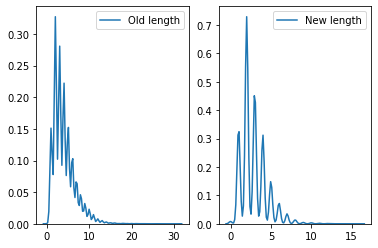

In [19]:
#Summary
old_len=[]
new_len=[]
for i in tqdm(range(len(df))):
    old_len.append(len(df.iloc[i]['Summary'].split()))
    new_len.append(len(df.iloc[i]['clean_summary'].split()))

print('Mean and median of previous lengths')
print(np.mean(old_len))
print(np.median(old_len))

print('\nMean and Median of clean data length')
print(np.mean(new_len))
print(np.median(new_len))


fig, axs = plt.subplots(ncols=2)
plt.figure(1)
plt.subplot(121)
ax=sns.distplot(old_len,kde=True,hist=False,label="Old length")
plt.subplot(122)
ax=sns.distplot(new_len,hist=False,label="New length")


100%|██████████████████████████████████████████████████████████████████████████| 42511/42511 [00:16<00:00, 2513.86it/s]


Mean and median of previous lengths
78.20074804168333
56.0

Mean and Median of clean data length
38.454305944343815
27.0


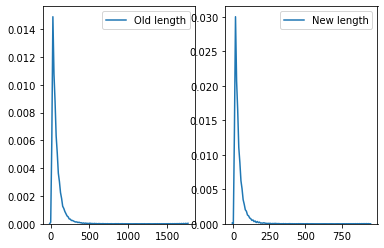

In [20]:
#Text 
old_len=[]
new_len=[]
for i in tqdm(range(len(df))):
    old_len.append(len(df.iloc[i]['Text'].split()))
    new_len.append(len(df.iloc[i]['Clean_Text'].split()))


print('Mean and median of previous lengths')
print(np.mean(old_len))
print(np.median(old_len))

print('\nMean and Median of clean data length')
print(np.mean(new_len))
print(np.median(new_len))

fig, axs = plt.subplots(ncols=2)
plt.figure(1)
plt.subplot(121)
ax=sns.distplot(old_len,kde=True,hist=False,label="Old length")
plt.subplot(122)
ax=sns.distplot(new_len,hist=False,label="New length")
plt.show()


In [21]:
# now we have cleaned the text so we need to remove the rows that were having garbage
df.head()
df.drop(['Text','Summary'],axis=1,inplace=True)

In [22]:
df.drop('Id',axis=1,inplace=True)

In [23]:
# saving back the cleaned data at particular location
df.to_csv(r'D:\study material\ML\Datasets\amazon-fine-food-reviews\Reviews_cleaned.csv',index=False)